# Содержание
- [1. Загрузка данных и их первоначальный анализ](#1)
    - [1.1 Подготовка к работе](#2)
    - [1.2 Загрузим и изучим данные](#3)
        - [1.2.1 Датасет - календарь маркетинговых событий](#4)
        - [1.2.2 Датасет - новые пользователи](#5)
        - [1.2.3 Датасет - участники тестов](#6)
        - [1.2.4 Датасет - действие новых пользователей](#7)
        - [1.2.5 Промежуточный вывод после изучения данных](#8)
    - [1.3 Предобработка данных](#9)
        - [1.3.1 Корректировка типов данных](#10)
        - [1.3.2 Исключение пользователей зарегистрировавшихся после 21.12.2020](#11)
        - [1.3.3 Исключение пользователей другого тестирования и сверка итогового количества участников с ожидаемым](#12)
        - [1.3.4 Анализ пропусков в данных о деталях событий](#13)
        - [1.3.5 Сбор данных и проверка на неучтенных пользователей](#14)
        - [1.3.6 Добавление столбца только с датой события](#15)
        - [1.3.7 Оценка лайфтаймов пользователей](#16)
        - [1.3.8 Промежуточный вывод после предобработки данных](#17)
- [2. Оценка корректости проведения теста](#18)
    - [2.1 Проверка на соотвествие ТЗ (пользователи из EU)](#19)
    - [2.2 Проверка времени проведения теста на пересение с другими событиями](#20)
    - [2.3 Проверка аудитории тестирования](#21)
        - [2.3.1 Пересечение пользователей между группами исследуемого А/В теста](#22)
        - [2.3.2 Пересечение пользователей между исследуемым и конкурирующим тестом](#23)
        - [2.3.3 Распределение пользователей в каждой исследуемой группе](#24)
    - [2.4 Промежуточный вывод после оценки корректности проведения теста](#25)
- [3. Исследовательский анализ данных](#26)
    - [3.1 Количество событий на пользователя](#27)
    - [3.2 Количество событий по дням](#28)
    - [3.3 Изучим воронку событий](#29)
    - [3.4 Промежуточный вывод после анализа](#30)
- [4. Оценка результатов А/В тестирования](#31)
    - [4.1 Распределение пользователей по событиям внутри групп](#32)
    - [4.2 Проверка результатов с помощью z-теста](#33)
- [5. Общий вывод](#34)

# Исследование и анализ результатов А/В тестирования

Цель - провести оценку результатов А/В тестирования по изменениям, связанным с внедрением улучшенной рекомендательной системы.

Входные данные - техническое задание, датасет с действиями пользователей, календарь маркетинговых событий на 2020 год, данные пользователей зарегистрированных с 7 по 12 декабря 2020 года, а также таблица итоговых участников тестов.

Задачи:
- Загрузим все датасеты, изучим данные в них и проведем их обработку
- Проверим корректность проведения теста
- Проведем исследовательский анализ данных
- Проанализируем статистические значимости различий в метриках и вынесем решение по результатам теста

## Загрузка данных и их первоначальный анализ
<a id='1'></a>

### Подготовка к работе
<a id='2'></a>

Перед началом работы, выведем все функции, которые понадобятся нам для работы, а также импортируем все необходимые библиотеки

In [1]:
#Определим функцию для вывода всей информации о данных в таблице
def inf_data(df):
    print('Первые 10 строк таблицы')
    display(df.head(10))
    pd.set_option('display.max_columns', None)
    print('----------')
    
    print('Общая информация о таблице')
    df.info()
    print('----------')
    
    print('Выведем наименование колонок')
    display(df.columns)
    print('----------')
    
    print('Посмотрим на типы данных')
    display(df.dtypes)
    print('----------')
    
    print('Проверим присутствуют ли пропуски в данных')
    display(df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False))
    print('----------')
    
    print('Проверим присутствуют ли явные дубликаты в данных')
    if df.duplicated().sum() == 0:
        print('Явных дубликатов нет')
    else:
        print('В наших данных {} записи являются дубликатами'.format(len(data[data.duplicated()])))
        display(df[df.duplicated()].head())

In [2]:
#Импортируем все необходимые библиотеки
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import math as mth

### Загрузим и изучим данные
<a id='3'></a>

В качестве входных данных у нас 4 разных датасета, содержащих всю необходимую информацию о пользователях. Сначала необходимо загрузить все данные и изучить их на наличие стандартных возможных ошибок, а также на соответствие всем пунктам технического задания

Техническое задание:
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

#### Датасет - календарь маркетинговых событий
<a id='4'></a>

Загрузим и изучим датасет о маркетинговых событиях

In [3]:
#Загрузим наши данные
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [4]:
#Посмотрим основную информацию об имеющихся данных
inf_data(marketing_events)

Первые 10 строк таблицы


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


----------
Общая информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
----------
Выведем наименование колонок


Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

----------
Посмотрим на типы данных


name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

----------
Проверим присутствуют ли пропуски в данных


Series([], dtype: int64)

----------
Проверим присутствуют ли явные дубликаты в данных
Явных дубликатов нет


In [5]:
print('Начало всех маркетинговых событий - {}, завершение всех маркетинговых событий - {}'
      .format(marketing_events['start_dt'].min(), marketing_events['finish_dt'].max()))

Начало всех маркетинговых событий - 2020-01-25, завершение всех маркетинговых событий - 2021-01-07


У нас дана информация о 14 маркетинговых событиях, состоявшихся с 25 января 2020 года по 7 января 2021 года, с наименованием события и регионом проведения.

Пропусков и дубликатов в данных мы не имеем. Однако мы видим, что информация о датах представлена не в верном типе данных. Это необходимо будет скорректировать

In [6]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

События проводились в 6 регионах.

#### Датасет - новые пользователи
<a id='5'></a>

Загрузим и изучим данные о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года

In [7]:
#Загрузим наши данные
try:
    users_new = pd.read_csv('final_ab_new_users.csv')
except:
    users_new = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')

In [8]:
#Посмотрим основную информацию об имеющихся данных
inf_data(users_new)

Первые 10 строк таблицы


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


----------
Общая информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
----------
Выведем наименование колонок


Index(['user_id', 'first_date', 'region', 'device'], dtype='object')

----------
Посмотрим на типы данных


user_id       object
first_date    object
region        object
device        object
dtype: object

----------
Проверим присутствуют ли пропуски в данных


Series([], dtype: int64)

----------
Проверим присутствуют ли явные дубликаты в данных
Явных дубликатов нет


In [9]:
print('Дата самой первой регистрации - {}, дата самой последней регистрации - {}'
      .format(users_new['first_date'].min(), users_new['first_date'].max()))

Дата самой первой регистрации - 2020-12-07, дата самой последней регистрации - 2020-12-23


У нас дана информация о 61733 пользователей, впервые зарегистрировавшихся с 7 по 23 декабря 2020 года, с информацией о регионе и устройстве регистрации.

Мы видим, что представлена информация в более больших временных рамках, что нам необходимо, то есть часть пользователей необходимо будет исключить.

Пропусков и дубликатов в данных мы не имеем. Однако мы видим, что информация о дате регистрации представлена не в верном типе данных. Это необходимо будет скорректировать.

Посмотрим, присутствуют ли пользователи зарегистрировавшиеся не один раз

In [10]:
users_new['user_id'].nunique()

61733

Так как количество уникальных идентификаторов пользователей соответсвует количеству зарегистрировавшихся пользователей, делаем вывод, что все пользователи зарегистрировались в представленны интервал времени единожды.

Посмотрим в каких регионах и через какие устройства регистрировались пользователи

In [11]:
users_new['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [12]:
users_new['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Представлено всего 4 региона регистрации и 4 устройства.

#### Датасет - участники тестов
<a id='6'></a>

Загрузим и изучим данные об итоговых участниках тестирования

In [13]:
#Загрузим наши данные
try:
    test_users = pd.read_csv('final_ab_participants.csv')
except:
    test_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [14]:
#Посмотрим основную информацию об имеющихся данных
inf_data(test_users)

Первые 10 строк таблицы


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


----------
Общая информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
----------
Выведем наименование колонок


Index(['user_id', 'group', 'ab_test'], dtype='object')

----------
Посмотрим на типы данных


user_id    object
group      object
ab_test    object
dtype: object

----------
Проверим присутствуют ли пропуски в данных


Series([], dtype: int64)

----------
Проверим присутствуют ли явные дубликаты в данных
Явных дубликатов нет


У нас представлена информация о 18268 участниках тестирования с определением группы теста и с его наименованием.

Типы данных верны, пропусков и явных дубликатов не обнаружено.

Групп проведения теста должно быть вего две:
- А - контрольная,
- В - новая платежная воронка

Наименование у теста должно быть одно "recommender_system_test".

Посмотрим не появилось ли случайно других групп тестирования, а также другого наименования теста

In [15]:
test_users['group'].unique()

array(['A', 'B'], dtype=object)

In [16]:
test_users['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Группы теста всего две, как и необходимо, а вот среди нужного нам теста появился и другой тест под названием "interface_eu_test". Его участников нужно будет исключить. И после проверить количество участников нужного нам теста и сверить это количество с ожидаемым

#### Датасет - действие новых пользователей
<a id='7'></a>

Загрузим и изучим данные о действиях пользователей в период с 7 декабря 2020 года по 4 января 2021 года

In [17]:
#Загрузим наши данные
try:
    test_users_events = pd.read_csv('final_ab_events.csv')
except:
    test_users_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')

In [18]:
#Посмотрим основную информацию об имеющихся данных
inf_data(test_users_events)

Первые 10 строк таблицы


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


----------
Общая информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
----------
Выведем наименование колонок


Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

----------
Посмотрим на типы данных


user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

----------
Проверим присутствуют ли пропуски в данных


details    377577
dtype: int64

----------
Проверим присутствуют ли явные дубликаты в данных
Явных дубликатов нет


In [19]:
print('Дата самого первого действия пользователей - {}, дата самого последнего действия пользователей - {}'
      .format(test_users_events['event_dt'].min(), test_users_events['event_dt'].max()))

Дата самого первого действия пользователей - 2020-12-07 00:00:33, дата самого последнего действия пользователей - 2020-12-30 23:36:33


У нас данные о 440317 действиях совершенных пользователями во время проведения тестирования, с информацией о дате и время реализации действия, типа события и его деталях.

Дубликатов не найдено. Однако присутствует большое количество пропусков в данных о деталях событий - их необходимо будет изучить.

Также неверен тип данных в столбце с датой и временем совершения события - нужно будет скорректировать тип. По ТЗ тест должен был проводится до 4 января 2021 года, однако дата самого последнего действия - 30 декабря 2020 года.

Посмотрим из каких событий состоят данные

In [20]:
test_users_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Пользователи совершали всего 4 действия:
- purchase - покупка,
- product_cart - просмотр корзины,
- product_page - просмотр карточек товаров,
- login - вход в личный кабинет.

#### Промежуточный вывод после изучения данных
<a id='8'></a>

Необходимо будет:
- скорректировать тип данных столбцов с датами в:
    - календаре маркетинговых событий,
    - данных о регистрации новых пользователей,
    - событиях пользователей;
- исключить пользователей, зарегистрировавшихся после 21 декабря 2020 года,
- исключить пользователей из другого тестирования ("interface_eu_test"),
- сверить итоговое количество участников теста с ожидаемым
- изучить пропуски в данных о деталях событий

После необходимо будет объединить все необходимые данные и:
- проверить нет ли в тесте неучтенных пользователей,
- добавить столбец с датой события (без времени),
- посмотреть на лайфтаймы пользователей (дата события - дата регистрации) и исключить события, которым более 14 дней с даты регистрации - потому что это уже будут события не относящеся к воздействию на пользователя улучшенной рекомендательной системы.

После всех корректировок необходимо будет оценить корректность проведения теста, а именно:
- проверить данные на следующее соответствие ТЗ - в тесте должно быть отобрано 15% новых пользователей из региона EU,
- проверить, что время проведения теста не совпадает с маркетинговыми событиями,
- проверить, что каждый пользователь попал только в одну группу (А или В) и количество визитов в каждой исследуемой группе должно быть примерно одинаковым, а также попал ли хоть один пользователей нашего теста во второй проверочный тест

Приступим к обработки данных

### Предобработка данных
<a id='9'></a>

#### Корректировка типов данных
<a id='10'></a>

Столбцы с информацией о датах имеют не верный тип данных в датасетах о:
- календаре маркетинговых событий,
- данных о регистрации новых пользователей,
- событиях пользователей.

Изменим тип данных на верный

In [21]:
marketing_events['start_dt'] = marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events['finish_dt'] = marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
users_new['first_date'] = users_new['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
test_users_events['event_dt'] = test_users_events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

Проверим все ли типы данных верно скорректировались

In [22]:
print(marketing_events['start_dt'].dtypes)
print(marketing_events['finish_dt'].dtypes)
print(users_new['first_date'].dtypes)
print(test_users_events['event_dt'].dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


Теперь все типы временных данных верны. Все временные рамки нужно будет еще раз проверить после завершения всей предобработки.

#### Исключение пользователей зарегистрировавшихся после 21.12.2020
<a id='11'></a>

Согласно ТЗ дата остановки набора новых пользователей - 21 декабря 2020 года. Однако в наших данных присутствует информация о пользователях зарегистрированных позже этой даты. Необходимо исключить их из анализа

In [23]:
users_after = users_new.query('first_date > "2020-12-21"')
print('Количество пользователей, зарегистрированных после 21.12.2020 года - {}'
      .format(len(users_after)))
print('Доля пользователей, зарегистрированных после 21.12.2020 года - {0:.2%}'
      .format(len(users_after)/len(users_new)))

Количество пользователей, зарегистрированных после 21.12.2020 года - 5263
Доля пользователей, зарегистрированных после 21.12.2020 года - 8.53%


Около 8,5% пользователей не соответствуют ТЗ. Исключаем их из анализа

In [24]:
users_new_filt = users_new.query('first_date <= "2020-12-21"')
print('Количество пользователей, зарегистрированных в необходимый интервал времени - {}'
      .format(len(users_new_filt)))

Количество пользователей, зарегистрированных в необходимый интервал времени - 56470


В итоге в нашем распоряжении информация о 56470 новых пользователях

#### Исключение пользователей другого тестирования и сверка итогового количества участников с ожидаемым
<a id='12'></a>

Согласно ТЗ наше тестирование должно наименоваться "recommender_system_test", однако мы выяснили, что в данных присутствуют пользователи из другого тестирования. Необходимо их исключить

In [25]:
test_users_other = test_users.query('ab_test != "recommender_system_test"')
print('Количество пользователей из другого тестирования - {}'
      .format(len(test_users_other)))
print('Доля пользователей из другого тестирования - {0:.2%}'
      .format(len(test_users_other)/len(test_users)))

Количество пользователей из другого тестирования - 11567
Доля пользователей из другого тестирования - 63.32%


Информация о более 63% пользователей относится к другому тестированию. Исключаем их из анализа

In [26]:
test_users_filt = test_users.query('ab_test == "recommender_system_test"')
print('Количество пользователей из нашего тестирования - {}'
      .format(len(test_users_filt)))

Количество пользователей из нашего тестирования - 6701


В итоге в нашем распоряжении информация о 6701 пользователе нашего тестирования, что даже немног более ожидаемого количества участников согласно ТЗ (6000).

#### Анализ пропусков в данных о деталях событий
<a id='13'></a>

Напомним какие пропуски были найдены

Количество пропущенных значений


details    377577
dtype: int64

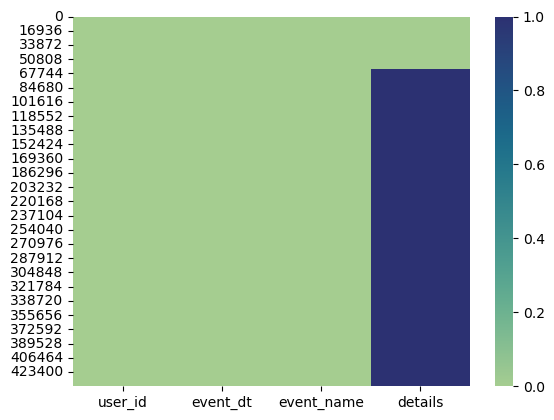

In [27]:
sns.heatmap(test_users_events.isna(), cmap='crest');
print('Количество пропущенных значений')
test_users_events.isna().sum()[test_users_events.isna().sum()>0]

Присутствует 377577 пропущенных значений в информации о деталях событий. Посмотрим для каких событий отсутствует информация о деталях

In [28]:
test_users_events.query('details.isna()')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

В 3 из 4 событий нет информации о деталях. Посмотрим действительно ли информация о деталях события есть только в типе "покупка", а в остальных отсутствует

In [29]:
print('Детали события "покупка" - {}'
      .format(test_users_events.query('event_name == "purchase"')['details'].unique()))
print('Детали события "просмотр корзины" - {}'
      .format(test_users_events.query('event_name == "product_cart"')['details'].unique()))
print('Детали события "просмотр карточек товаров" - {}'
      .format(test_users_events.query('event_name == "product_page"')['details'].unique()))
print('Детали события "вход в личный кабинет" - {}'
      .format(test_users_events.query('event_name == "login"')['details'].unique()))

Детали события "покупка" - [ 99.99   9.99   4.99 499.99]
Детали события "просмотр корзины" - [nan]
Детали события "просмотр карточек товаров" - [nan]
Детали события "вход в личный кабинет" - [nan]


Мы видим, что детали есть только у события "покупка" - и это информация о стоимости покупки в долларах. Для всех остальных событий дополнительной информации нет.

Теперь объединим все необходимые данные и проверим нет ли в тесте неучтенных пользователей

#### Сбор данных и проверка на неучтенных пользователей
<a id='14'></a>

Сначала объединим информацию о зарегистрированных пользователях и пользователях вошедших в тестирование

In [30]:
all_users = (
    test_users_filt
    .merge(users_new_filt, on='user_id', how='outer')
)

Количество пропущенных значений


group      49769
ab_test    49769
dtype: int64

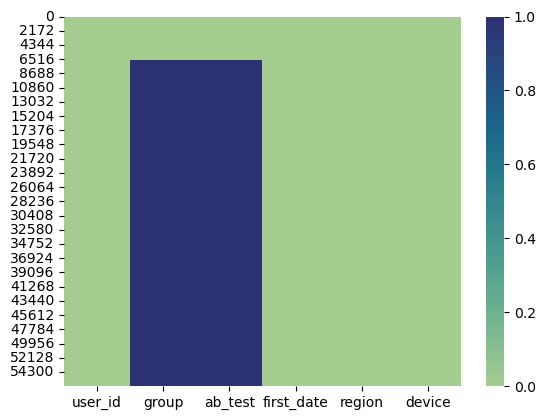

In [31]:
#Проверим пропуски после объединения
sns.heatmap(all_users.isna(), cmap='crest');
print('Количество пропущенных значений')
all_users.isna().sum()[all_users.isna().sum()>0]

49769 пользователей зарегистрированных с 7 по 21 декабря 2020 года не приняло участие в нашем А/В тестировании. Для дальнейшего анализа результатов А/В тестирования нам не нужна информация о пользователях не участвующих в тестировании, поэтому оставим только нужных пользователей. Произведем объединение таблиц по принципу - объединять по тем пользователям, что есть в тестировании

In [32]:
all_users = (
    test_users_filt
    .merge(users_new_filt, on='user_id', how='left')
)

Количество пропущенных значений


Series([], dtype: int64)

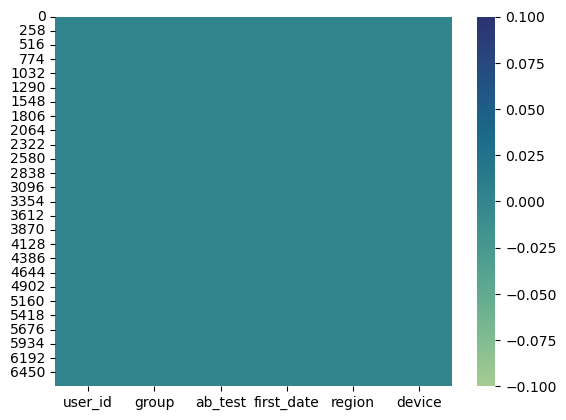

In [33]:
#Проверим пропуски после объединения
sns.heatmap(all_users.isna(), cmap='crest');
print('Количество пропущенных значений')
all_users.isna().sum()[all_users.isna().sum()>0]

Мы видим, что пропусков нет, это означает, что все пользователи участвующие в нужном тестировании действительно были зарегистирированы в необходимом нам интервале.

Теперь объединим полученную таблицу с данными о событиях совершенных пользователями. И так как нужна информация, только о действиях пользователей попавших в тестирование, объединим таблицу соответствующим образом

In [34]:
all_users_test = (
    all_users
    .merge(test_users_events, on='user_id', how='left')
)

Количество пропущенных значений


event_dt       3026
event_name     3026
details       24393
dtype: int64

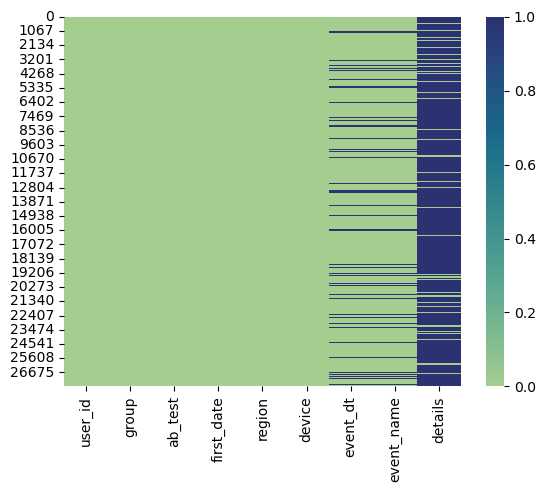

In [35]:
#Проверим пропуски после объединения
sns.heatmap(all_users_test.isna(), cmap='crest');
print('Количество пропущенных значений')
all_users_test.isna().sum()[all_users_test.isna().sum()>0]

После итогового объединения - пропуски в деталях для нас ожидаемые (о них мы знали заранее), а вот 3026 пропущенных значений в типе и дате события говорит о том, что не все пользователи вошедшие в тестирование совершали хоть действия. Посмотрим на это несоответствие во время исследовательского анализа

In [36]:
#Сохраним размер нашей сборной таблицы
original_size_all = len(all_users_test)
print('Размер итоговой таблицы - {}'.format(original_size_all))

Размер итоговой таблицы - 27724


Для дальнейшего анализа нам понадобятся данные лишь о дате события, так что создадим отдельный столбец

#### Добавление столбца только с датой события
<a id='15'></a>

In [37]:
all_users_test['event_date'] = all_users_test['event_dt'].dt.date
all_users_test['event_date'] = pd.to_datetime(all_users_test['event_date'])

#### Оценка лайфтаймов пользователей
<a id='16'></a>

Посчитаем в отдельном столбце лайфтайл каждого события пользователя и исключим события старше 14 дней

In [38]:
all_users_test['lt'] = all_users_test['event_date'] - all_users_test['first_date']

all_users_test['lt'] = all_users_test['lt'].astype('timedelta64[D]')

print('Количество событий старше 14 дней - {}'
      .format(len(all_users_test.query('lt > 14'))))

#Исключаем события старше 14 дней
all_users_test = all_users_test.query('lt <= 14 or lt.isna()')
print('Количество исключенных событий - {}'
      .format(original_size_all - len(all_users_test)))

print('Количество пользователей, участвующих в тестировании - {}'
      .format(all_users_test['user_id'].nunique()))

Количество событий старше 14 дней - 628
Количество исключенных событий - 628
Количество пользователей, участвующих в тестировании - 6701


Исключили 628 событий превышающих 14 дневный лайфтайм, при этом количество пользователей не изменилось - 6701.

In [39]:
#Пересчитаем размер нашей сборной итоговой таблицы
original_size_all = len(all_users_test)
print('Размер итоговой таблицы - {}'.format(original_size_all))

Размер итоговой таблицы - 27096


#### Промежуточный вывод после предобработки данных
<a id='17'></a>

В процессе обработки данных мы:
- скорректировали типы временных данных,
- исключили 5263 пользователя, зарегистрированных после 21 декабря 2020 года,
- оставили 56470 пользователей, зарегистрированных в нужном интервале (с 7 по 21 декабря 2020 года),
- исключили 11567 пользователей, относящихся к другому тестированию,
- оставили 6701 пользователей, относящихся к нашему тестированию (что чуть больше ожидаемого количества согласно ТЗ),
- выяснили, что дополнительная информация есть только для события "покупка" и это стоимость этой покупки в долларах, для остальных событий доп информации нет
- объединили все данные о пользователях, попавших в наше А/В тестирование, выяснили что есть пользователи не совершавших действия - посмотрим на них на этапе анализа,
- исключили 628 событий превышающих 14 дневный лайфтайм,
- а также добавили новый столбец с датой события (без времени).

Итоговая таблица для дальнейшего анализа со всей информациией о пользователях (вошедших в А/В тестирование) состоит из 27096 строк.

Далее проверим корректность проведения тестирования

## Оценка корректости проведения теста
<a id='18'></a>

Для проверки корректности проведения тестирования нам необходимо:
- проверить данные на оставшееся соответствие ТЗ - в тесте должно быть отобрано 15% новых пользователей из региона EU,
- проверить, что время проведения теста не совпадает с маркетинговыми событиями,
- проверить, что каждый пользователь попал только в одну группу (А или В) и количество визитов в каждой исследуемой группе должно быть примерно одинаковым

### Проверка на соотвествие ТЗ (пользователи из EU)
<a id='19'></a>

Посмотрим сколько пользователей всего было зарегистрировано в период с 7 по 21 декабря из региона EU, а также солколько пользователей из данного региона попали в тестирование

In [40]:
print('Количество пользователей из EU, зарегистрированых с 7 по 21 декабря - {}'
      .format(len(users_new_filt.query('region == "EU"'))))
print('-----------------')

print('Количество пользователей из EU, участвующих в тестировании - {}'
      .format(all_users_test.query('region == "EU"')['user_id'].nunique()))
print('-----------------')

print('Доля пользователей из EU в тестировании из общей массы этого региона - {0:.2%}'
      .format(all_users_test.query('region == "EU"')['user_id'].nunique() /
              len(users_new_filt.query('region == "EU"'))))

Количество пользователей из EU, зарегистрированых с 7 по 21 декабря - 42340
-----------------
Количество пользователей из EU, участвующих в тестировании - 6351
-----------------
Доля пользователей из EU в тестировании из общей массы этого региона - 15.00%


Таким образом видим, что действительно 15% новых пользователей из EU отобралось для тестирования. Нам необходимо чтобы итоговое количество пользователей в тесте было 6000, и так как 6351 пользователь из EU, а из других регионов гораздо меньше, то оставляем лишь пользователей из EU

In [41]:
all_users_test = all_users_test.query('region == "EU"')

### Проверка времени проведения теста на пересение с другими событиями
<a id='20'></a>

Нам необходимо выяснить есть ли маркетинговые события которые могу пересекаться с датами проведения нашего тестирования. Для этого исключим события закончившиеся до 7 декабря 2020 года (до даты начала нашего тестирования) и события не проходящие в EU (так как пользователи для нашего анализа именно из этого региона)

In [42]:
marketing_events.query('finish_dt >= "2020-12-07" and regions.str.contains("EU")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


В итоге нашлось всего 1 маркетинговое событие, даты проведения которого пересекаются с проведением нашего А/В тестирования. При анализе распределения аудитории нужно будет внимательнее посмотреть на распределение участников в интервале с 25 декабря 2020 года (время прохождения маркетингового события)

### Проверка аудитории тестирования
<a id='21'></a>

Для проверки аудитории тестирования нам необходимо оценить:
- есть ли пересечение пользователей между группами нашего А/В теста,
- есть ли пересечение пользователей нашего теста с конкурирующим тестом ("interface_eu_test"),
- распределение количество пользователей в каждой исследуемой группе - оно должно быть примерно одинаковым

#### Пересечение пользователей между группами исследуемого А/В теста
<a id='22'></a>

Чтобы найти пользователей попавших сразу в обе группы, необходимо сгруппировать наши данные по пользователям и посмотреть сколько уникальных групп у каждого из них. И если хоть у одного из них будет 2 группы - значит этот пользователь попал в обе группы и в А и в В.

In [43]:
print('Количество пользователей, попавших сразу в обе исследуемые группы - {}'
      .format(len(all_users_test
                  .groupby('user_id', as_index=False)
                  .agg({'group':'nunique'})
                  .query('group > 1'))
             )
     )

Количество пользователей, попавших сразу в обе исследуемые группы - 0


Таким образом видим, что каждый пользователь попал лишь в одну из групп

#### Пересечение пользователей между исследуемым и конкурирующим тестом
<a id='23'></a>

Создадим список уникальных идентификаторов пользователей попавших в наш исследуемый тест и посмотрим, присутствуют ли пользователи с этими идентификаторами в данных о проведении конкурирующего теста "interface_eu_test"

In [44]:
id_udser_ab = list(all_users_test['user_id'].unique())

print('Количество пользователей исследуемого теста, попавших в конкурирующий тест - {}'
      .format(test_users_other
              .query('user_id in @id_udser_ab')['user_id']
              .nunique())
     )

Количество пользователей исследуемого теста, попавших в конкурирующий тест - 1602


1602 пользователя (из 6351 участника нашего тестирования) исследуемого теста оказались участниками и конкурирующего теста. 
Посмотрим на распределение этих участников в нашей группе.

In [45]:
#Создадимм список уникальных идентификаторов пользователей попавших в оба теста
id_user_other = list(test_users_other.query('user_id in @id_udser_ab')['user_id'].unique())

#Создадим таблицу с данными о пользователях, попавших в оба теста
common_users = all_users_test.query('user_id in @id_user_other')

#Создадим таблицу с данными о пользователях, попавших только в наше тестирование
dif_users = all_users_test.query('user_id not in @id_user_other')

#Посмотрим на распределение этих участников в каждой группе теста
common_users_group = common_users.groupby('group', as_index=False).agg({'user_id':'nunique'})
common_users_group['perc'] = common_users_group['user_id'] / common_users_group['user_id'].sum() * 100

#Посмотрим на распределение участников, попавших только в наш тест, в каждой группе теста
dif_users_group = dif_users.groupby('group', as_index=False).agg({'user_id':'nunique'})
dif_users_group['perc'] = dif_users_group['user_id'] / dif_users_group['user_id'].sum() * 100

#Посмотрим на распределение всех участников в каждой группе теста
all_users_test_group = all_users_test.groupby('group', as_index=False).agg({'user_id':'nunique'})
all_users_test_group['perc'] = all_users_test_group['user_id'] / all_users_test_group['user_id'].sum() * 100

print('Распределение участников, попавших в оба теста по группам')
display(common_users_group)
print('Распределение участников, попавших только в наш тест по группам')
display(dif_users_group)
print('Распределение всех участников теста в каждой группе')
all_users_test_group

Распределение участников, попавших в оба теста по группам


,group,user_id,perc
0,A,921,57.490637
1,B,681,42.509363


Распределение участников, попавших только в наш тест по группам


,group,user_id,perc
0,A,2713,57.127816
1,B,2036,42.872184


Распределение всех участников теста в каждой группе


,group,user_id,perc
0,A,3634,57.219336
1,B,2717,42.780664


Мы видим, что доли распределения и всех участников, и тех которые попали в оба теста одинаковые, и тех что оказались только в нашем тестировании - большая часть (около 57%) попала в группу А, меньшая (около 42%) в группу В, причем даже процентное соотношение одинаковое. Посмотрим, как распределились участники по датам совершения событий

In [46]:
#Посмотрим на распределение всех участников по датам событий
all_users_test_date = all_users_test.groupby('event_date', as_index=False).agg({'user_id':'nunique'})
all_users_test_date['perc'] = round(all_users_test_date['user_id'] / all_users_test_date['user_id'].sum() * 100, 2)

#Посмотрим на распределение участников, попавших в оба теста по датам событий
common_users_date = common_users.groupby('event_date', as_index=False).agg({'user_id':'nunique'})
common_users_date['perc'] = round(common_users_date['user_id'] / common_users_date['user_id'].sum() * 100, 2)

#Посмотрим на распределение участников, попавших только в наше тестирование
dif_users_date = dif_users.groupby('event_date', as_index=False).agg({'user_id':'nunique'})
dif_users_date['perc'] = round(dif_users_date['user_id'] / dif_users_date['user_id'].sum() * 100, 2)

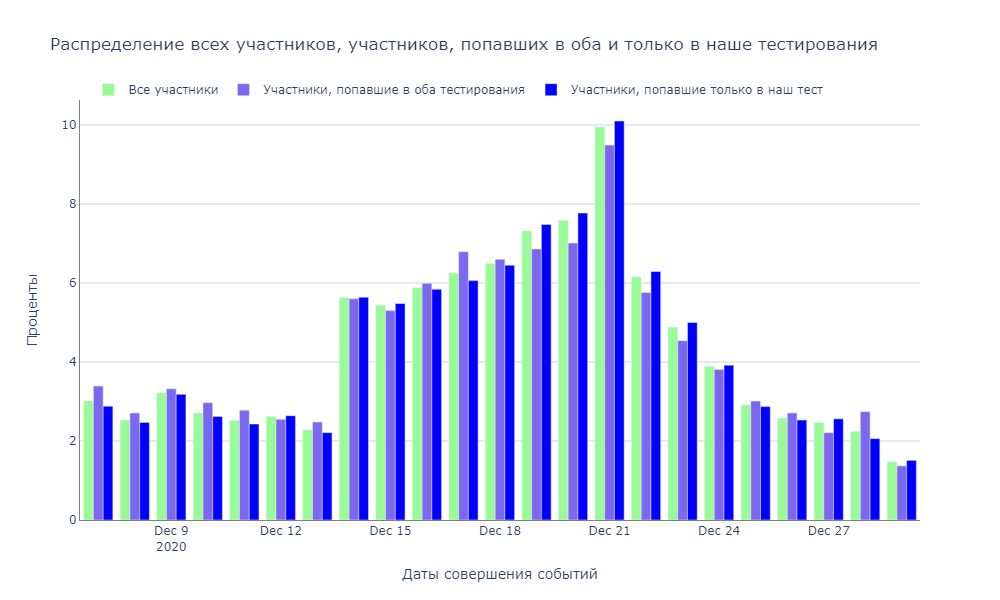

In [47]:
#Выведем график распределения участников на экран
fig = go.Figure()

fig.add_trace(
    go.Bar(x=all_users_test_date['event_date'],
           y=all_users_test_date['perc'],
           text=all_users_test_date['perc'],
           cliponaxis=False,
           marker_color='palegreen',
           hovertemplate="%{x} значение %{y}%",
           name='Все участники'
          )
)

fig.add_trace(
    go.Bar(x=common_users_date['event_date'],
           y=common_users_date['perc'],
           text=common_users_date['perc'],
           cliponaxis=False,
           marker_color='mediumslateblue',
           hovertemplate="%{x} значение %{y}%",
           name='Участники, попавшие в оба тестирования'
          )
)

fig.add_trace(
    go.Bar(x=dif_users_date['event_date'],
           y=dif_users_date['perc'],
           text=dif_users_date['perc'],
           cliponaxis=False,
           marker_color='blue',
           hovertemplate="%{x} значение %{y}%",
           name='Участники, попавшие только в наш тест'
          )
)

fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', title='Даты совершения событий')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey', title='Проценты')

fig.update_layout(legend_orientation='h',
                  legend=dict(yanchor='bottom', xanchor='left', y=0.99, x=0.01),
                  plot_bgcolor='white',
                  title_text='Распределение всех участников, участников, попавших в оба и только в наше тестирования')

fig.update_traces(textposition='none')

fig.show(renderer='png', width=1000, height=600, scale=None)

Как мы видим, распределение участников по датам также распределено практически одинаково и для участников попавших в оба тестирования и только в наше. Общие скачки в совершении событий 14 и 21 декабря и общее падение 22 декабря. 

Также мы сразу видим, что начало маркетингового события 25 декабря никак не оказывает влияние (например, отсутствует увеличение количества событий с этой даты) на пользователей. 

Из этого можно сделать вывод, что нет необходимости исключать пользователей попавших в оба тестирования, а также действия пользователей во время маркетингового события.

#### Распределение пользователей в каждой исследуемой группе
<a id='24'></a>

Необходимо сгруппировать пользователей по группам и оценить их распределение внутри групп

In [48]:
#Проверим количество уникальных пользователей попавших в кажду группу
print('Количество уникальных посетителей во всем исследовании - {}'
      .format(all_users_test['user_id'].nunique()))
print()
print('Количество уникальных посетителей в каждой группе')
all_users_test_group

Количество уникальных посетителей во всем исследовании - 6351

Количество уникальных посетителей в каждой группе


,group,user_id,perc
0,A,3634,57.219336
1,B,2717,42.780664


Количество уникальных пользователей в группах достаточно сильно отличаются - в группе А на 917 участников больше (это почти 14% от всех участников). Посмотрим на распределение посетителей в группах на каждую дату регистрации и на каждую дату совершения событий

In [49]:
#Распределение на каждую дату регистрации
all_users_test_fdate = (
    all_users_test
    .pivot_table(index='first_date', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
)

all_users_test_fdate['% A'] = (
    (round(all_users_test_fdate['A']/all_users_test_fdate[['A', 'B']].sum(axis=1)*100, 2))
)

all_users_test_fdate['% B'] = (
    (round(all_users_test_fdate['B']/all_users_test_fdate[['A', 'B']].sum(axis=1)*100, 2))
)

#Распределение на каждую дату совершения события
all_users_test_edate = (
    all_users_test
    .pivot_table(index='event_date', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
)

all_users_test_edate['% A'] = (
    (round(all_users_test_edate['A']/all_users_test_edate[['A', 'B']].sum(axis=1)*100, 2))
)

all_users_test_edate['% B'] = (
    (round(all_users_test_edate['B']/all_users_test_edate[['A', 'B']].sum(axis=1)*100, 2))
)

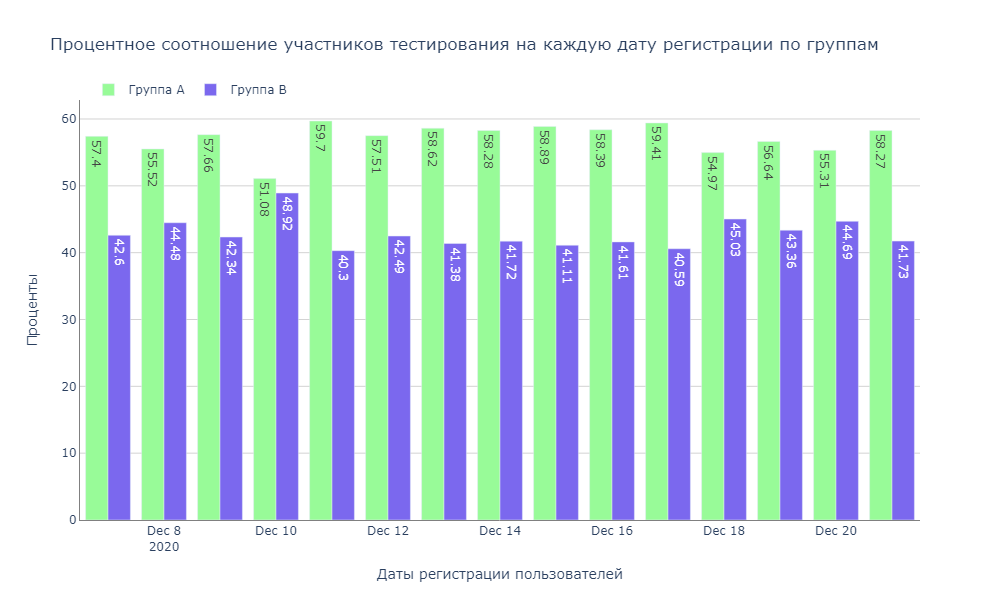

In [50]:
#Выведем график распределения участников по регистрации на экран
fig = go.Figure()

fig.add_trace(
    go.Bar(x=all_users_test_fdate['first_date'],
           y=all_users_test_fdate['% A'],
           text=all_users_test_fdate['% A'],
           cliponaxis=False,
           marker_color='palegreen',
           name='Группа А',
           hovertemplate="%{x} значение %{y}%"
          )
)

fig.add_trace(
    go.Bar(x=all_users_test_fdate['first_date'],
           y=all_users_test_fdate['% B'],
           text=all_users_test_fdate['% B'],
           cliponaxis=False,
           marker_color='mediumslateblue',
           name='Группа В',
           hovertemplate="%{x} значение %{y}%"
          )
)

fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', title='Даты регистрации пользователей')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey', title='Проценты')

fig.update_layout(legend_orientation='h',
                  legend=dict(yanchor='bottom', xanchor='left', y=0.99, x=0.01),
                  plot_bgcolor='white',
                  title_text='Процентное соотношение участников тестирования на каждую дату регистрации по группам')

fig.update_traces(textposition='inside')

fig.show(renderer='png', width=1000, height=600, scale=None)

Как мы видим, на каждую дату регистрации (с 7 по 21 декабря 2020) количество участников теста в группе А всегда больше, чем в группе В (примерно на 14-16%), только в один день 10 декабря разница между участниками групп минимальна - в этот день зарегистрирующиеся пользователи попали в обе группы примерно в одинаковом соотношении.

Из этого можно сделать вывод, что присутствует проблема распределения участников по группам - большая часть пользователей попали в группу А (контрольную). 

Посмотрим, сколько уникальных пользователей каждый день тестирования совершали события

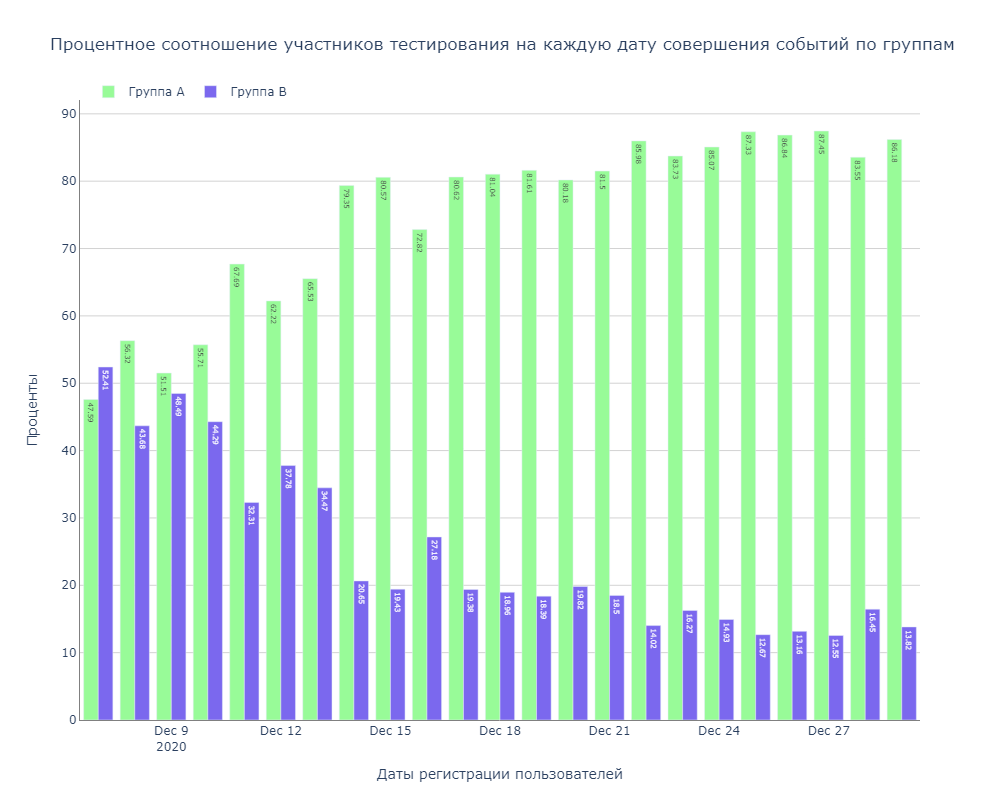

In [51]:
#Выведем график распределения участников на дату совершения событий на экран
fig = go.Figure()

fig.add_trace(
    go.Bar(x=all_users_test_edate['event_date'],
           y=all_users_test_edate['% A'],
           text=all_users_test_edate['% A'],
           cliponaxis=False,
           marker_color='palegreen',
           name='Группа А',
           hovertemplate="%{x} значение %{y}%"
          )
)

fig.add_trace(
    go.Bar(x=all_users_test_edate['event_date'],
           y=all_users_test_edate['% B'],
           text=all_users_test_edate['% B'],
           cliponaxis=False,
           marker_color='mediumslateblue',
           name='Группа В',
           hovertemplate="%{x} значение %{y}%"
          )
)

fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', title='Даты регистрации пользователей')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey', title='Проценты')

fig.update_layout(legend_orientation='h',
                  legend=dict(yanchor='bottom', xanchor='left', y=0.99, x=0.01),
                  plot_bgcolor='white',
                  title_text='Процентное соотношение участников тестирования на каждую дату совершения событий по группам')

fig.show(renderer='png', width=1000, height=800, scale=None)

Видим, что только в самый первый день больше пользователи группы В совершали действия, но начиная со следующего дня именно больше пользователей группы А совершали действия, а 5 дня тестирования (с 11 декабря 2020 года) все меньшее количество пользователей группы В были активны. И к окончанию тестирования разница между количеством активных пользователей групп составила около 72% (в группе А больше активых)

Посмотрим на итоговое количество участников и событий в тестировании

In [52]:
print(
    'Общее количество событий - {}'
      .format(all_users_test['event_name'].count())
)
print()
print(
    'Общее количество пользователей - {}'
      .format(all_users_test['user_id'].nunique())
)

Общее количество событий - 22828

Общее количество пользователей - 6351


### Промежуточный вывод после оценки корректности проведения теста
<a id='25'></a>

В итоговых данных для оценки результатов тестирования:
- все данные соответствовали ТЗ и было 6351 участников из EU,
- с 25 декабря 2020 года (во время проведения нашего А/В тестирования) проходило маркетинговое событие - однако оно не оказало влияния на действия пользователей,
- каждый пользователь попал лишь в одну из групп,
- обнаружились пользователи участвующие и в нашем и в конкурирующем тесте, однако после их анализа выяснили, что эти пользователи распределены равномерно и не оказывают влияния на результаты тестирования,
- обнаружилось, что пользователи между группами распределены не равномерно - примерно на 14% в группу А попало больше пользователей чем в группу В, а также количество акивных пользователей в группе А в разы превышает количество активных группы В

Таким образом можно сделать вывод, что данные тестирования соответсвуют ТЗ, однако подготовка тестирования возможно была выполнена не корректно из-за не верного распределения пользователей по группам, совмещения тестирования, маркетингового события, а также пересечения пользователей с конкурирующим тестом.

**Итоговая таблица для дальнейшего анализа** со всей информациией о пользователях (вошедших в А/В тестирование) состоит из 22828 событий - в ней 6351 участник тестирования зарегистрированный с 07 по 21 декабря 2020 года, совершающие действия с 7 по 29 декабря 2020 года.

Данные проверены и готовы к анализу

## Исследовательский анализ данных
<a id='26'></a>

В процессе анализа нам необходимо определить:
- одинаково ли распределены в выборках количество событий на пользователя,
- как число событий в выборках распределено по дням,
- как меняется конверсия в воронке в выборках на разных этапах

### Количество событий на пользователя
<a id='27'></a>

Понимаем, что каждый пользователь мог совершить 1, 2 ... действий (в каждой группе), а кто то мог просто зарегистрировать без совершения дальнейших событий. Необходимо получить эти данные

In [53]:
#Сначала получим данные по количеству совершенных действий пользователями
event_users = (
    all_users_test.groupby('user_id', as_index=False)
    .agg({'event_name':'count'})
    .merge(test_users_filt[['user_id','group']], on='user_id', how='left')
    .sort_values(by='event_name', ascending=False)
)

print('Пользователи, совершившие события - {}'
      .format(len(event_users.query('event_name > 0'))))

print('Доля пользователей, совершивших события, от общего числа участников - {0:.2%}'
      .format(len(event_users.query('event_name > 0'))
              /all_users_test['user_id'].nunique()))
print('')
print('Пользователи, не совершившие не одного действия - {}'
      .format(len(event_users.query('event_name == 0'))))

print('Доля пользователей, не совершивших события, от общего числа участников - {0:.2%}'
      .format(len(event_users.query('event_name == 0'))
              /all_users_test['user_id'].nunique()))

Пользователи, совершившие события - 3481
Доля пользователей, совершивших события, от общего числа участников - 54.81%

Пользователи, не совершившие не одного действия - 2870
Доля пользователей, не совершивших события, от общего числа участников - 45.19%


Видим, что около 45% участников тестирования прошли только этап регистрации и более ничего не совершали. Посмотрим на этих пользователей внимательнее:
- из каких групп тестирования,
- с каких устройств проходили регистрацию,
- в какие даты проходили регистрацию

In [54]:
#Создадим список идентификаторов пользователей без действий
users_not_events = list(event_users.query('event_name == 0')['user_id'])

print('Группы тестирования пользователей без действий:')
display(event_users
        .query('user_id in @users_not_events')
        .groupby('group')
        .agg({'user_id':'count'}))
print('')
print('Устройства регистрации пользователей без действий:')
display(all_users_test
        .query('user_id in @users_not_events')
        .groupby('device')
        .agg({'user_id':'count'}))
print('')
print('Даты регистрации пользователей без действий:')
display(all_users_test
        .query('user_id in @users_not_events')
        .groupby('first_date')
        .agg({'user_id':'count'}))

Группы тестирования пользователей без действий:


,user_id
group,
A,1030
B,1840



Устройства регистрации пользователей без действий:


,user_id
device,
Android,1274
Mac,275
PC,720
iPhone,601



Даты регистрации пользователей без действий:


,user_id
first_date,
2020-12-07,283
2020-12-08,203
2020-12-09,87
2020-12-10,278
2020-12-11,157
2020-12-12,355
2020-12-13,485
2020-12-14,194
2020-12-15,110


Видим, что большая часть пользователей без действий:
- расположились в группе В (с изменениями), но их также много и в группе А,
- пользователи регистрировались во все даты со всех устройств. 

Значит нельзя предположить наличие технической ошибки из-за которой пользователи не могли совершать действия, скорее всего это не качественая и некорректная подготовка к тестированию - не корректное разбиение на группы и привлечение пользователей.

Посмотрим как распределены по группам пользователи совершавшие события

In [55]:
#Создадим список идентификаторов пользователей, совершавших действия
users_events = list(event_users.query('event_name > 0')['user_id'])

print('Группы тестирования пользователей с событиями:')
display(event_users
        .query('user_id in @users_events')
        .groupby('group')
        .agg({'event_name':'count'}))

print('Разница между событиями в группах - {} пользователей'.format(
     (event_users
        .query('user_id in @users_events')
        .groupby('group')
        .agg({'event_name':'count'}))['event_name']['A'] - 
    (event_users
        .query('user_id in @users_events')
        .groupby('group')
        .agg({'event_name':'count'}))['event_name']['B']
)
     )

Группы тестирования пользователей с событиями:


,event_name
group,
A,2604
B,877


Разница между событиями в группах - 1727 пользователей


Мы видим, что в группе А пользователей, совершивших события в разы больше, чем в группе В - на 1727 пользователей больше. Вновь это говорит о некорректном планировании и проведении тестирования

Посмотрим, какое количество событий пользователей встречается чаще всего, для этого построим точечную диаграмму событий по пользователям

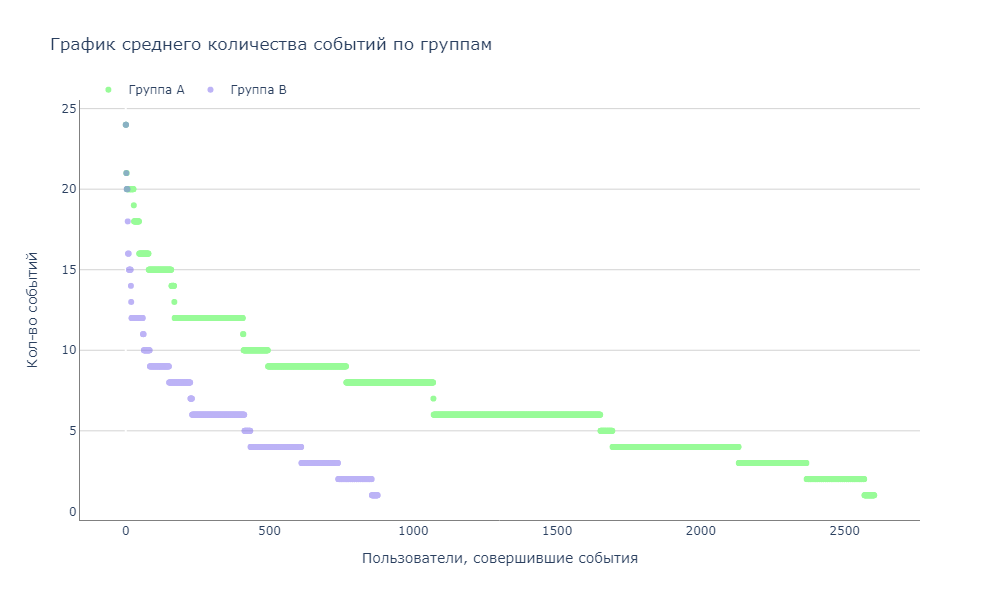

In [56]:
#Выведем график распределения участников на дату совершения событий на экран
fig = go.Figure()

#серия из чисел от 0 до количества наблюдений в данных по количеству совершенных событий для групп
x_values_A = pd.Series(range(0, len(event_users.query('event_name > 0 and group == "A"'))))
x_values_B = pd.Series(range(0, len(event_users.query('event_name > 0 and group == "B"'))))

fig.add_trace(
    go.Scatter(x=x_values_A,
               y=event_users.query('event_name > 0 and group == "A"')['event_name'],
               marker_color='palegreen',
               mode='markers',
               name='Группа А'
          )
)

fig.add_trace(
    go.Scatter(x=x_values_B,
               y=event_users.query('event_name > 0 and group == "B"')['event_name'],
               opacity=0.5,
               marker_color='mediumslateblue',
               mode='markers',
               name='Группа B'
          )
)

fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', title='Пользователи, совершившие события')
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey', title='Кол-во событий')

fig.update_layout(legend_orientation='h',
                  legend=dict(yanchor='bottom', xanchor='left', y=0.99, x=0.01),
                  plot_bgcolor='white',
                  title_text='График среднего количества событий по группам')

fig.show(renderer='png', width=1000, height=600, scale=None)

Видим подтверждение, что больше пользователей совершают события в группе А.

Также видим, что большее количество пользователей (в обеих группах) совершили от 1 до 6 событий.

### Количество событий по дням
<a id='28'></a>

Посмотрим, как распределяется совершение событий пользователями по дням в каждой группе

In [57]:
event_user_date = (
    all_users_test
    .query('~event_name.isna()')
    .pivot_table(index='event_date', columns='group', values='event_name', aggfunc='count', margins=True)

)

event_user_date['% A'] = round(
    event_user_date['A']/
    event_user_date['All']*100,
    2)

event_user_date['% B'] = round(
    event_user_date['B']/
    event_user_date['All']*100,
    2)

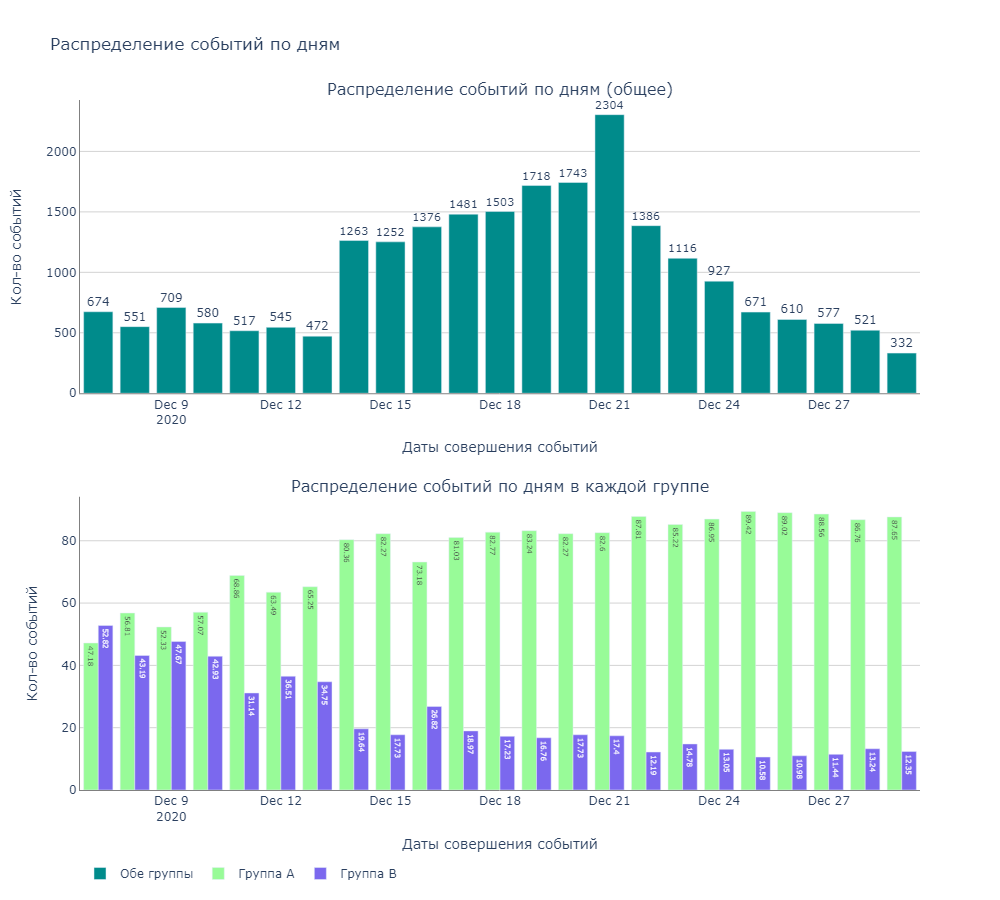

In [58]:
fig = make_subplots(
    rows=2, cols=1,
    horizontal_spacing=0.15,
    vertical_spacing=0.15,
    specs=[[{}],
           [{}]],
    subplot_titles=("Распределение событий по дням (общее)", "Распределение событий по дням в каждой группе")
)

fig.add_trace(
    go.Bar(x=event_user_date[:-1].index,
           y=event_user_date[:-1]['All'],
           text=event_user_date[:-1]['All'],
           cliponaxis=False,
           textposition='outside',
           hovertemplate="%{x} значение %{y}",
           marker_color='darkcyan',
           name='Обе группы'
          ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=event_user_date[:-1].index,
           y=event_user_date[:-1]['% A'],
           text=event_user_date[:-1]['% A'],
           cliponaxis=False,
           marker_color='palegreen',
           name='Группа А',
           hovertemplate="%{x} значение %{y}"
          ),
    row=2, col=1    
)

fig.add_trace(
    go.Bar(x=event_user_date[:-1].index,
           y=event_user_date[:-1]['% B'],
           text=event_user_date[:-1]['% B'],
           cliponaxis=False,
           marker_color='mediumslateblue',
           hovertemplate="%{x} значение %{y}",
           name='Группа В'
          ),
    row=2, col=1
)

fig.update_xaxes(title_text='Даты совершения событий',         
                 row=1, col=1)
fig.update_xaxes(title_text='Даты совершения событий',
                 row=2, col=1)
fig.update_xaxes(showline=True, linewidth=1, linecolor='grey')


fig.update_yaxes(title_text='Кол-во событий',         
                 row=1, col=1)
fig.update_yaxes(title_text='Кол-во событий',
                 row=2, col=1)
fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', gridcolor='lightgrey')


fig.update_layout(autosize=False,
                  width=980,
                  height=950,
                  plot_bgcolor='white',
                  legend_orientation='h',
                  title='Распределение событий по дням'
                 )
fig.show(renderer='png', width=1000, height=900, scale=None)

Видим, что с 14 по 21 декабря идет увеличение количества действий пользователями, причем пользователями группы А. В группе В именно с 14 декабря идет резкое уменьшение активности пользователей. С 22 декабря (после завершения регистрации новых пользователей) происходит резкое падение количества событий, также за счет уменьшения активности пользователей группы В.

Можно сделать вывод, что в группе В оказалось не только недостаточное количество пользователей, но и они же оказались мало активными

### Изучим воронку событий
<a id='29'></a>

Изучим события более детально:
- как часто встречается каждое событие,
- сколько пользователей совершило каждое событие,
- какой порядок перехода по событиям,
- какая доля пользователей переходит с этапа на этап и где больше всего теряем,
- какая доля изначальных пользователей доходит до оплаты.

Напомним, пользователи совершали всего 4 действия после прохождения регистрации:
- login - вход в личный кабинет,
- product_page - просмотр карточек товаров,
- product_cart - просмотр корзины,
- purchase - покупка.

Посмотрим какое количество каждого события совершали пользователи

In [59]:
event = all_users_test['event_name'].value_counts().reset_index()
event = event.rename(columns={'event_name':'event_count'})
event

,index,event_count
0,login,10313
1,product_page,6382
2,purchase,3123
3,product_cart,3010


Как мы видим количество "покупок" больше количества "просмотров корзины". Скорее всего, это связано с реализацией возможности "быстрой оплаты", когда пользователь может оформить оплату непосредственно с карточки товара, не выходя на окно "корзины".

Теперь посмотрим, какое количество уникальных пользователей совершали каждое событие

In [60]:
#Оценим сколько пользователей совершило каждое событие
print('Общее количество пользователей - {}'
      .format(all_users_test['user_id'].nunique()))
print('')
print('Распределение пользователей по событиям:')
all_users_test_event = (
    all_users_test.groupby('event_name')
    .agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)

#Доля пользователей, которые хоть раз совершали событие от общего кол-ва пользователей
all_users_test_event['perc_user_all'] = round(
    all_users_test_event['user_id'] /
    all_users_test['user_id'].nunique()
    *100,
    2
)

#Доля пользователей, которые хоть раз совершали событие от кол-ва пользователей с событиями
all_users_test_event['perc_user_event'] = round(
    all_users_test_event['user_id'] / 
    all_users_test.query('~event_name.isna()')['user_id'].nunique()
    *100,
    2
)

#Объединяем с таблицей о количестве действий каждого события
all_users_test_event = (
    all_users_test_event
    .merge(event, left_on='event_name', right_on='index', how='left')
)

all_users_test_event = all_users_test_event[['event_name', 'event_count', 'user_id', 'perc_user_all', 'perc_user_event']]
all_users_test_event

Общее количество пользователей - 6351

Распределение пользователей по событиям:


,event_name,event_count,user_id,perc_user_all,perc_user_event
0,login,10313,3480,54.79,99.97
1,product_page,6382,2178,34.29,62.57
2,purchase,3123,1082,17.04,31.08
3,product_cart,3010,1026,16.15,29.47


Мы видим, что из-за того что почти половина участников не выполнила не одного события, до "покупки" дошло около 17% от всех участников, но около 31% от пользователей с событиями.

Больше всего пользователей (3480) вошли в личный кабинет, но это не все из тех, что совершали события. Скорее всего это из-за того, что например, для просмотра товаров не обязательно заходить в личный кабинет.

Также мы видим, большое количество события "вход в личный кабинет", которое гораздо больше количества пользователей, совершивших это действие - скорее всего это связано с тем, что пользователи принудительно выходят из кабинета либо учетная запись вылетает.

На втором месте по пользователя (2178) - просмотр карточек товаров.

Далее идет событие "покупки" - 1082 пользователя совершили событие 3123 раза - значит 1 пользователь совершает примерно 3 покупки.

И немного меньше пользователей (1026) посещяют корзину. Значит почти все кто смотрит корзину, производит оплату, но некоторые пользователи пользуются "быстрой оплатой".

Создадим таблицу для визуализации воронки продаж. Но сначала нужно выставить верный порядок прохождения этапов

In [61]:
#Сначала сделаем столбец события категориальным и укажем порядок использования
all_users_test_event['event_name'] = pd.Categorical(
    all_users_test_event['event_name'], ["login", "product_page", "product_cart", "purchase"]
)

#Теперь, при сортировке столбца событий, он будет сортироваться по этому списку:
all_users_test_event = all_users_test_event.sort_values("event_name")

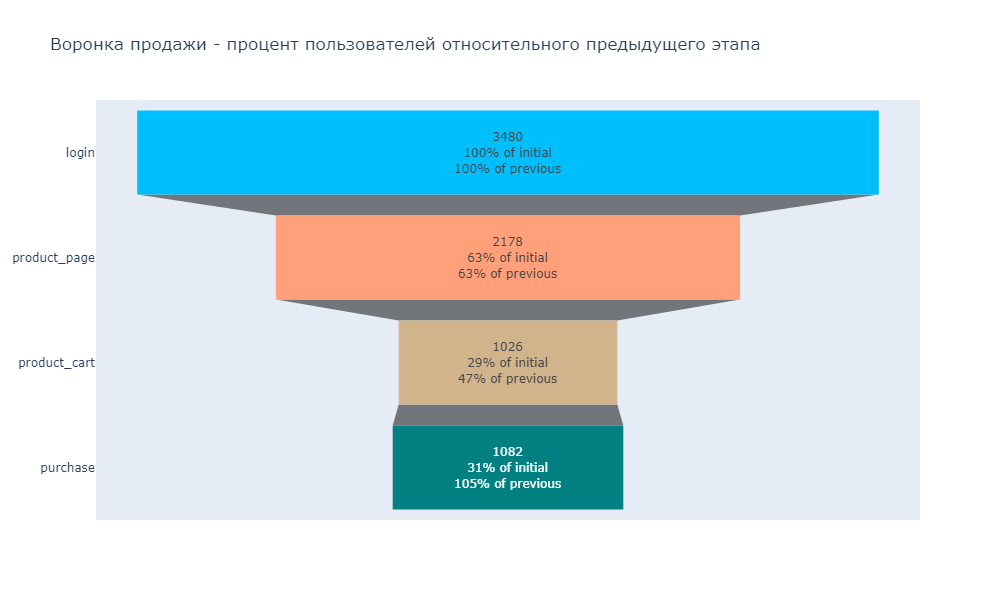

In [62]:
#Построим воронку по переходам пользователей от шага к шагу
#с процентным оотношением от шага к шагу, чтобы понять
#какой процент пользователей проходит на след этап
#относительно предыдущего
fig = go.Figure(
    go.Funnel(y = all_users_test_event['event_name'],
              x = all_users_test_event['user_id'],
              marker = {"color": ['deepskyblue', 'lightsalmon', 'tan', 'teal']},
              textposition = "inside",
              textinfo = "value+percent previous+percent initial")
)
fig.update_layout(
    title='Воронка продажи - процент пользователей относительного предыдущего этапа')
fig.show(renderer='png', width=1000, height=600, scale=None)

Мы видим, что большая часть пользователей (53%) теряется при переходе с просмотра карточек товаров на просмотр корзины. Однако до покупки доходит на 5% больше пользователей (из-за функции "быстрой оплаты"), значит в действительности около 50% из тех, что просматривает товары не доходят до покупки.

Также мы видим, что большая часть пользователей (37%) теряется при переходе с личного кабинета на просмотр карточек товаров. Это тоже достаточно большой процент потери заинтересованности - возможно:
- не интуитивно понятный интерфейс личного кабинета, что осложняет переход с него на экран выбора товаров,
- у пользователей нет заинтересованности в товаре

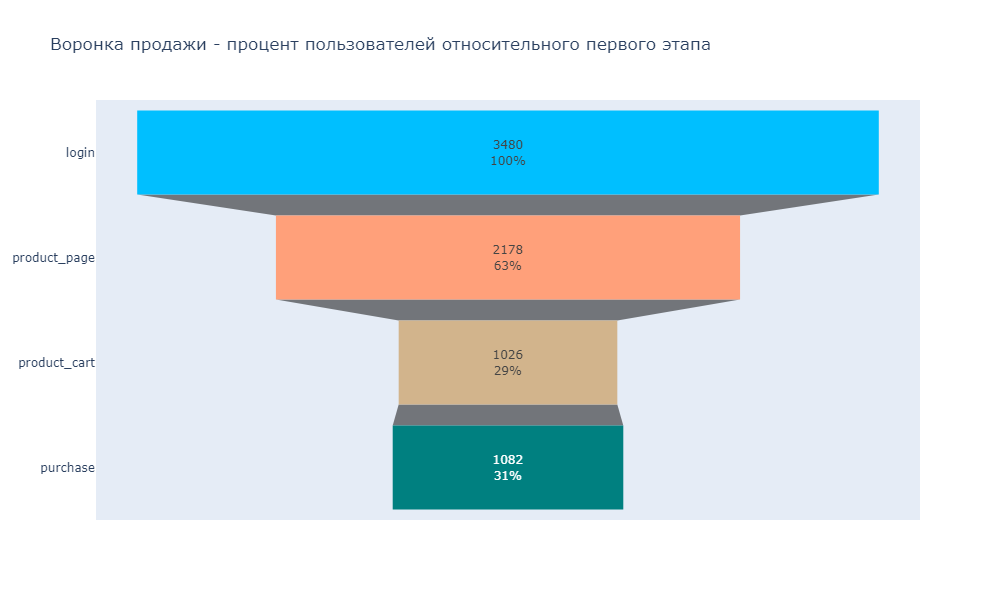

In [63]:
#Построим воронку по переходам пользователей от шага к шагу
#с процентным оотношением к первому шагу,
#чтобы понять сколько пользователей от изначального количества
#поэтапно доходит до успешной оплаты
fig = go.Figure(
    go.Funnel(y = all_users_test_event['event_name'],
              x = all_users_test_event['user_id'],
              marker = {"color": ['deepskyblue', 'lightsalmon', 'tan', 'teal']},
              textposition = "inside",
              textinfo = "value+percent initial")
)
fig.update_layout(
    title='Воронка продажи - процент пользователей относительного первого этапа')
fig.show(renderer='png', width=1000, height=600, scale=None)

31% от всех пользователей совершивших действия после регистрации доходят до покупки.

### Промежуточный вывод после анализа
<a id='30'></a>

Выяснили, что около 45% участников тестирования прошли только этап регистрации и более ничего не совершали. Так как такие пользователи регистрировались во все даты со всех устройств и попали в обе группы, нельзя предположить наличие технической ошибки из-за которой пользователи не могли совершать действия, скорее всего это не корректное разбиение на группы и привлечение пользователей.

Среди тех пользователей, что совершили события после регистрации:
- в группе А пользователи совершили в разы больше событий, чем в группе В - на 1727 событий больше, вновь это говорит о некорректном планировании и проведении тестирования,
- большее количество пользователей (в обеих группах) совершили от 1 до 6 событий.

Выяснили, что с 14 по 21 декабря идет увеличение количества действий пользователями, причем пользователями группы А. В группе В именно с 14 декабря идет резкое уменьшение активности пользователей. С 22 декабря (после завершения регистрации новых пользователей) происходит резкое падение количества событий, также за счет уменьшения активности пользователей группы В.

Можно сделать вывод, что в группе В оказалось не только недостаточное количество пользователей, но и они же оказались мало активными

Изучая совершенные события, отметили, что из-за того что почти половина участников не выполнила не одного события, до "покупки" дошло около 17% от всех участников.

Распределение по пользователям совершившим события:
- больше всего пользователей (3480) вошли в личный кабинет, но это не все из тех, что совершали события. Скорее всего это из-за того, что например, для просмотра товаров не обязательно заходить в личный кабинет,
- на втором месте по пользователя (2178) - просмотр карточек товаров,
- далее идет событие "покупки" - 1082 пользователя совершили событие 3123 раза - значит 1 пользователь совершает примерно 3 покупки,
- немного меньше пользователей (1026) посещяют корзину, скорее всего почти все кто смотрит корзину, производит оплату, но некоторые пользователи пользуются "быстрой оплатой"

Потери пользователей:
- большая часть пользователей (53%) теряется при переходе с просмотра карточек товаров на просмотр корзины. Однако до покупки доходит на 5% больше пользователей (из-за функции "быстрой оплаты"), значит в действительности около 50% из тех, что просматривает товары не доходят до покупки,
- также большая часть пользователей (37%) теряется при переходе с личного кабинета на просмотр карточек товаров. Это тоже достаточно большой процент потери заинтересованности - возможно:
  - не интуитивно понятный интерфейс личного кабинета, что осложняет переход с него на экран выбора товаров,
  - у пользователей нет заинтересованности в товаре

По итогу 31% от всех пользователей, совершивших действия после регистрации, доходят до покупки.

Хоть тестирование выполнено не корректно, но мы посмотрим на результаты тестирования. Однако доверять им я бы не советовала

## Оценка результатов А/В тестирования
<a id='31'></a>

Оценивания результаты тестирования, посмотрим на пользователей внутри групп, а также оценим статистическую разницу долей с помощью z-критерия

### Распределение пользователей по событиям внутри групп
<a id='32'></a>

Посмотрим, как распределились пользователи по событиям в каждой из групп

In [64]:
#Определим количество пользователей в каждой группе для каждого события
users_event_group = (
    all_users_test
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
)

#Сделаем столбец события категориальным и укажем порядок использования
users_event_group['event_name'] = pd.Categorical(
    users_event_group['event_name'], ["login", "product_page", "product_cart", "purchase"]
)

#Теперь, при сортировке столбца событий, он будет сортироваться по этому списку:
users_event_group = users_event_group.sort_values("event_name")
users_event_group

group,event_name,A,B
0,login,2604,876
2,product_page,1685,493
1,product_cart,782,244
3,purchase,833,249


In [65]:
#И определим общее количество пользователей в каждой группе,
#интересут пользователи и те что совершали события, и без них
all_users_event_group = (
    all_users_test
    .pivot_table(index='group', values='user_id', aggfunc='nunique')
    .T
)
all_users_event_group

group,A,B
user_id,3634,2717


Посмотрим на воронку продаж по группам

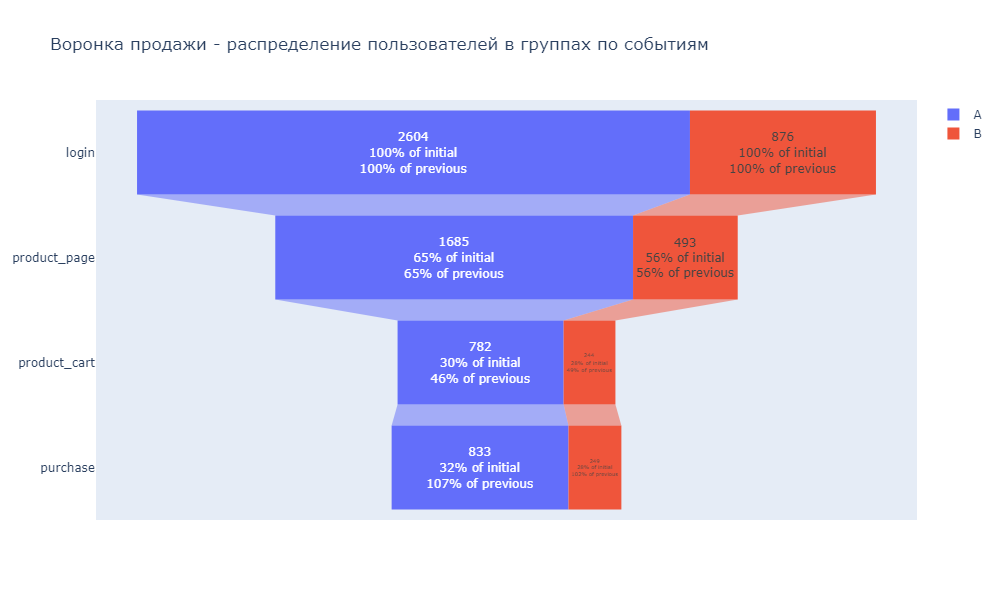

In [66]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = str('A'),
    y = users_event_group['event_name'],
    x = users_event_group['A'],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = str('B'),
    orientation = "h",
    y = users_event_group['event_name'],
    x = users_event_group['B'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.update_layout(
    title='Воронка продажи - распределение пользователей в группах по событиям')

fig.show(renderer='png', width=1000, height=600, scale=None)

Вновь мы видим, что в контрольной группе А гораздо больше пользователей с событиями.

Также видно, что каждая конверсия из этапа в этап в группе В хуже, чем в группе А. Также в группе В хуже и процент дошедших до покупки пользователей (в групее А дошло 32%, в группе В - 28,4%).

### Проверка результатов с помощью z-теста
<a id='33'></a>

Необходимо проверить результаты А/В тестирования с помощью z-теста (проверка гипотезы о равенстве долей - сравнение пропорций двух генеральных совокупностей по выборкам из них).

Сравниваем выборки для каждого события - общее количество пользователей в каждой группе и количество пользователей с событием в группе.

**Сформулируем гипотезы**:

*Нулевая гипотеза* - Нет статистически значимой разницы между группами

*Альтернативная гипотеза* - Существует существенная разница между пропорциями в группах

In [67]:
alpha = .05
for ev in users_event_group['event_name'].unique():
    #Успешное - пользователи с событиями в группе
    successes = np.array(
        [users_event_group[users_event_group['event_name'] == ev]['A'],
         users_event_group[users_event_group['event_name'] == ev]['B']]
    )
    
    #Общее - общее число пользователей в группе
    trials = np.array(
        [all_users_event_group['A'], 
         all_users_event_group['B']]
    )
    
    #пропорция успехов в первой группе
    p1 = successes[0] / trials[0]
    
    #пропорция успехов во второй группе
    p2 = successes[1] / trials[1]
    
    #пропорция успехов в комбинированной группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    #Разница пропорций
    difference = p1 - p2
    
    #Считаем статистику
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    #Задаем нормальное распределение
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if ev == 'login' :
        print('Сравнение группы A и B события - {} (вход в личный кабинет), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    if ev == 'product_page' :
        print('Сравнение группы A и B события - {} (выбор товаров у офферов), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    if ev == 'product_cart' :
        print('Сравнение группы A и B события - {} (просмотр корзины), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()
        
    if ev == 'purchase' :
        print('Сравнение группы A и B события - {} (успешная оплата), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        print('')

Сравнение группы A и B события - login (вход в личный кабинет), с критическим уровнем стат значимости 0.05

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравнение группы A и B события - product_page (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравнение группы A и B события - product_cart (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравнение группы A и B события - purchase (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница



Мы видим, что для всех событий разница между долями оказалась очень значительной. И так как в группе В недостаток активных пользователей, можно предположить, что пользователей экспериментальной группы В по отношению к контрольной группе А проявили себя хуже и изменения, связанные с внедрением улучшенной рекомендательной системы не оправдали себя.

Посмотрим как изменятся показатели нашей z-проверки, если за общее количество пользователей брать пользователей с событиями, а не всех

Сравниваем выборки для каждого события - количество пользователей со всеми событиями в каждой группе и количество пользователей с событием в группе.

**Сформулируем гипотезы**:

*Нулевая гипотеза* - Нет статистически значимой разницы между группами

*Альтернативная гипотеза* - Существует существенная разница между пропорциями в группах

In [68]:
all_users_event_group_2 = (
    all_users_test
    .query('~event_name.isna()')
    .pivot_table(index='group', values='user_id', aggfunc='nunique')
    .T
)
all_users_event_group_2

group,A,B
user_id,2604,877


In [69]:
alpha = .05
for ev in users_event_group['event_name'].unique():
    #Успешное - пользователи с событиями в группе
    successes = np.array(
        [users_event_group[users_event_group['event_name'] == ev]['A'],
         users_event_group[users_event_group['event_name'] == ev]['B']]
    )
    
    #Общее - общее число пользователей в группе
    trials = np.array(
        [all_users_event_group_2['A'], 
         all_users_event_group_2['B']]
    )
    
    #пропорция успехов в первой группе
    p1 = successes[0] / trials[0]
    
    #пропорция успехов во второй группе
    p2 = successes[1] / trials[1]
    
    #пропорция успехов в комбинированной группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    #Разница пропорций
    difference = p1 - p2
    
    #Считаем статистику
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    #Задаем нормальное распределение
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if ev == 'login' :
        print('Сравнение группы A и B события - {} (вход в личный кабинет), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    if ev == 'product_page' :
        print('Сравнение группы A и B события - {} (выбор товаров у офферов), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    if ev == 'product_cart' :
        print('Сравнение группы A и B события - {} (просмотр корзины), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()
        
    if ev == 'purchase' :
        print('Сравнение группы A и B события - {} (успешная оплата), с критическим уровнем стат значимости {}'
          .format(ev, alpha))
        print()

    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        print('')

Сравнение группы A и B события - login (вход в личный кабинет), с критическим уровнем стат значимости 0.05

p-значение:  [0.08481837]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы A и B события - product_page (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [6.94273936e-06]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравнение группы A и B события - product_cart (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.21469192]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы A и B события - purchase (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.04652483]
Отвергаем нулевую гипотезу: между долями есть значимая разница



При сравнении пропорций с количеством только пользователей с событиями:
- для событий `login` (вход в ЛК) и `product_cart` (просмотр корзины) - нет стат значимости между долями
- однако для событий `product_page` (просмотр карточек пользователей) и `purchase` (успешная оплата) - также разница очень значима.

А именно эти два события считаются самыми важными для бизнес целей.

## Общий вывод
<a id='34'></a>

Цель - провести оценку результатов А/В тестирования по изменениям, связанным с внедрением улучшенной рекомендательной системы.

В нашем распоряжении было техническое задание, датасет с действиями пользователей, календарь маркетинговых событий на 2020 год, данные новых пользователей, а также таблица итоговых участников тестов.

Иначально была предоставлена информация о:
- 14 маркетинговых событиях, состоявшихся с 25 января 2020 года по 7 января 2021 года, с наименованием события и регионом проведения,
- 61733 пользователей, впервые зарегистрировавшихся с 7 по 23 декабря 2020 года, с информацией о регионе и устройстве регистрации,
- 18268 участниках тестирования с определением группы теста и с его наименованием,
- 440317 действиях совершенных пользователями во время проведения тестирования, с информацией о дате и время реализации действия (с 7 декабря до 30 декабря 2020 года), типа события и его деталях.

Видим, что тестирование закончили раньше положенного - планировалось провеодить тест до 4 января 2021 года, однако информация о событиях пользователей до 30 декабря 2020 года.

После изучения информации выявили, что необходимо было:
- скорректировать тип данных столбцов с датами в:
    - календаре маркетинговых событий,
    - данных о регистрации новых пользователей,
    - событиях пользователей;
- исключить пользователей, зарегистрировавшихся после 21 декабря 2020 года,
- исключить пользователей из другого тестирования ("interface_eu_test"),
- сверить итоговое количество участников теста с ожидаемым
- изучить пропуски в данных о деталях событий,
- объединить все необходимые данные и:
    - проверить нет ли в тесте неучтенных пользователей,
    - добавить столбец с датой события (без времени),
    - посмотреть на лайфтаймы пользователей (дата события - дата регистрации) и исключить события, которым более 14 дней с даты регистрации - потому что это уже будут события не относящеся к воздействию на пользователя улучшенной рекомендательной системы.

Было сделано:
- скорректировали типы всех временных данных,
- исключено 5263 пользователя, зарегистрированных после 21 декабря 2020 года,
- исключено 11567 пользователей, относящихся к другому тестированию,
- оставили 6701 пользователей, относящихся к нашему тестированию,
- выяснили, что дополнительная информация есть только для события "покупка" и это стоимость этой покупки в долларах, для остальных событий доп информации нет,
- объединили все данные о пользователях, попавших в наше А/В тестирование, выяснили что есть пользователи не совершавших действия - посмотрим на них на этапе анализа,
- добавили новый столбец с датой события (без времени),
- оценили лайфтаймы пользователей и исключили 628 событий превышающих 14 дневный лайфтайм.

После всей обработки в нашем распоряжении осталась информация о:
- 14 маркетинговых событиях, состоявшихся с 25 января 2020 года по 7 января 2021 года, с наименованием события и регионом проведения,
- 56470 новых пользователях, зарегистрированных с 07 декабря по 21 декабря 2020 года, с информацией о регионе и устройстве регистрации,
- 6701 участников нашего тестирования с определением группы теста и с его наименованием (что чуть больше ожидаемого количества участников согласна ТЗ - 6000)

Далее оценили корректность проведения теста и выявили:
- все данные соответствовали ТЗ и оставили 6351 участников из EU,
- с 25 декабря 2020 года (во время проведения нашего А/В тестирования) проходило маркетинговое событие - однако оно не оказало влияния на действия пользователей,
- каждый пользователь попал лишь в одну из групп,
- обнаружились пользователи участвующие и в нашем и в конкурирующем тесте, однако после их анализа выяснили, что эти пользователи распределены равномерно и не оказывают влияния на результаты тестирования,
- обнаружилось, что пользователи между группами распределены не равномерно - примерно на 14% в группу А попало больше пользователей чем в группу В, а также количество акивных пользователей в группе А в разы превышает количество активных группы В

Таким образом можно сделать вывод, что данные тестирования соответсвуют ТЗ, однако подготовка тестирования возможно была выполнена не корректно из-за не верного распределения пользователей по группам, совмещения тестирования, маркетингового события, а также пересечения пользователей с конкурирующим тестом.

**Итоговая таблица для дальнейшего анализа** со всей информациией о пользователях (вошедших в А/В тестирование) состоит из 22828 событий - в ней 6351 участник тестирования зарегистрированный с 07 по 21 декабря 2020 года, совершающие действия с 7 по 29 декабря 2020 года.

**Оценивая корректность проведения тестирования, выяснили,** что около 45% участников тестирования прошли только этап регистрации и более ничего не совершали.

Среди тех пользователей, что совершили события после регистрации:
- в группе А пользователей, совершивших события в разы больше, чем в группе В - на 1727 пользователей больше,
- большее количество пользователей (в обеих группах) совершили от 1 до 6 событий.

Выяснили, что с 14 по 21 декабря идет увеличение количества действий пользователями, причем пользователями группы А. В группе В именно с 14 декабря идет резкое уменьшение активности пользователей. С 22 декабря (после завершения регистрации новых пользователей) происходит резкое падение количества событий, также за счет уменьшения активности пользователей группы В.

Изучая совершенные события, отметили, что из-за того что почти половина участников не выполнила не одного события, до "покупки" дошло около 17% от всех участников.

Распределение по пользователям совершившим события:
- больше всего пользователей (3480) вошли в личный кабинет, но это не все из тех, что совершали события. Скорее всего это из-за того, что например, для просмотра товаров не обязательно заходить в личный кабинет,
- на втором месте по пользователя (2178) - просмотр карточек товаров,
- далее идет событие "покупки" - 1082 пользователя совершили событие 3123 раза - значит 1 пользователь совершает примерно 3 покупки,
- немного меньше пользователей (1026) посещяют корзину, скорее всего почти все кто смотрит корзину, производит оплату, но некоторые пользователи пользуются "быстрой оплатой"

Потери пользователей:
- большая часть пользователей (53%) теряется при переходе с просмотра карточек товаров на просмотр корзины. Однако до покупки доходит на 5% больше пользователей (из-за функции "быстрой оплаты"), значит в действительности около 50% из тех, что просматривает товары не доходят до покупки,
- также большая часть пользователей (37%) теряется при переходе с личного кабинета на просмотр карточек товаров. Это тоже достаточно большой процент потери заинтересованности - возможно:
  - не интуитивно понятный интерфейс личного кабинета, что осложняет переход с него на экран выбора товаров,
  - у пользователей нет заинтересованности в товаре

По итогу 31% от всех пользователей, совершивших действия после регистрации, доходят до покупки.

По итогу анализа, можно утверждать, что тестирование организовано и проведено не корректно:
- в главную анализируемую группу (В) попало меньше пользователей, чем в контрольную,
- эти пользователи в основном не активные (без событий).

Скорее всего это не корректное разбиение на группы и привлечение пользователей.

Соответственно и результаты тестирования могут быть не корректными

**Оценка результатов тестирования**
По воронке событий по группам видно, что каждая конверсия из этапа в этап в группе В хуже, чем в группе А. Также в группе В хуже и процент дошедших до покупки пользователей (в групее А дошло 32%, в группе В - 28,4%).

Проверили результаты А/В тестирования с помощью z-теста (проверка гипотезы о равенстве долей - сравнение пропорций двух генеральных совокупностей по выборкам из них).

Сравнивали выборки для каждого события - общее количество пользователей в каждой группе и количество пользователей с событием в группе.

Сформулировали гипотезы:

*Нулевая гипотеза* - Нет статистически значимой разницы между группами

*Альтернативная гипотеза* - Существует существенная разница между пропорциями в группах

Для всех событий разница между долями оказалась очень значительной. И так как в группе В недостаток активных пользователей, можно предположить, что пользователей экспериментальной группы В по отношению к контрольной группе А проявили себя хуже и изменения, связанные с внедрением улучшенной рекомендательной системы **не оправдали себя**.

Так как данное тестирование прошло не корректно, могу предложить следующие рекомендации для будущих проведений тестирований:
- для оценки правильного распределения пользователей по группам следует изначально проводить А/А тестирование,
- не заканчивать тест раньше запланированного времени - в данном случае тестирование прервали за 5 дней до предполагаемого окончания